In [1]:
import numpy as np

# import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, CallBacks, Damping

# import rod class, damping and forces to be applied
from elastica.rod.cosserat_rod import CosseratRod
from elastica.dissipation import AnalyticalLinearDamper
from elastica.external_forces import GravityForces, MuscleTorques
from elastica.interaction import AnisotropicFrictionalPlane

# import timestepping functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod, GeneralConstraint, FixedConstraint
from elastica.external_forces import EndpointForces

# import call back functions
from elastica.callback_functions import CallBackBaseClass
from collections import defaultdict

import numpy as np
from elastica.rod.cosserat_rod import CosseratRod
from elastica.utils import MaxDimension

import os
import numpy as np
import elastica as ea


import numpy as np
from scipy.optimize import root_scalar

import numpy as np
from elastica.boundary_conditions import ConstraintBase
from elastica.typing import RodType

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import elastica as ea
from elastica.utils import MaxDimension
from elastica.dissipation import AnalyticalLinearDamper
from elastica.boundary_conditions import OneEndFixedRod
from elastica.external_forces import NoForces
from scipy.optimize import root_scalar

In [2]:
class FixedAngleBC(ConstraintBase):
    def __init__(self, pos0, dir0, dirN, **kwargs):
        super().__init__(**kwargs)
        self.pos0 = pos0
        self.dir0 = dir0
        self.dirN = dirN

    def constrain_values(self, rod, time):
        rod.position_collection[:, 0] = self.pos0
        rod.director_collection[..., 0] = self.dir0
        rod.director_collection[..., -1] = self.dirN

    def constrain_rates(self, rod, time):
        rod.velocity_collection[..., 0] = 0.0
        rod.omega_collection[..., 0] = 0.0
        rod.velocity_collection[..., -1] = 0.0
        rod.omega_collection[..., -1] = 0.0


BEAM EQUATION DIMENSIONAL

The dimensional form of the beam equation is:
$$ \rho A \frac{\partial^2 W}{\partial T^2}+ \Lambda \frac{\partial W}{\partial T} + E I \frac{\partial^4 W}{\partial X^4}+F \frac{\partial^2 W}{\partial X^2}=0$$
where $A=\pi r^2, \quad I=\frac{\pi r^4}{4}$. The boundary conditions are 
$$W(\pm 1/2L)=0,\quad W'(\pm 1/2L)=\pm \alpha,$$
and the constraint on the length is: 
$$\frac{1}{2}\int_0^1 \left(\frac{\partial W}{\partial X}\right)^2=\frac{\Delta L}{L }.$$

RESCALING:

Rescaling $X = L x, \quad W=\alpha L w, \quad F = F^* \tau^2$, $T= T^* t$ and $\Lambda = \Lambda^* \nu$ where 
$$F^*=E I /L^2, \quad T^*=L^2\sqrt{\frac{\rho A}{E I}}, \quad \Lambda^*=\frac{\sqrt{\rho A E I }}{L^2},$$
with the dimensionless equation becoming
$$ \frac{\partial^2 w}{\partial t^2}+ \nu \frac{\partial w}{\partial t} + \frac{\partial^4 w}{\partial x^4}+\tau^2 \frac{\partial^2 w}{\partial x^2}=0.$$
with boundary conditions
$$w(\pm 1/2)=0,\quad w'(\pm 1/2)=\pm 1,$$
and constraint
$$\frac{1}{2}\int_0^1 \left(\frac{\partial w}{\partial x}\right)^2=\mu,$$
where 
$$\mu= \frac{\Delta L}{\alpha^2 L }.$$

TIMESCALES:

The time a bending wave takes to travel through a single section of the discretised rod of length $dl$ is $$dt \approx (dl/L) T^* = dl L \sqrt{\frac{\rho A}{E I}}$$
Therfore, we also have that: 
$$\frac{\partial \mu}{\partial t}=\left(\frac{\partial \Delta L}{\partial T}\right) \frac{T^*}{L \alpha^2}$$
Meaning,
$$V=\frac{\partial \Delta L}{\partial T}= \frac{L \alpha^2}{T^*}\frac{\partial \mu}{\partial t}. $$



From PRL we know the critical $V^*$ is at $\dot{\mu}=0.1$, so that:
$$V^* = 0.1 \frac{L \alpha^2}{T^*}.$$

CRITICAL DAMPING:

For critical damping we need 

Define the key parameters in the problem:

In [3]:
# Options
PLOT_FIGURE = True
SAVE_FIGURE = True
SAVE_RESULTS = True
ADD_UNSHEARABLE_ROD = False

# setting up test params
n_elem = 80  # Number of elements
alpha = 0.1 # Clemp algle
mu = 0.5 # initial compression dimensionless number (mu = Delta_L / (alpha**2 * L)
g= 0.01 # gravity initial
t0 = 1.0 # time at which ends start moving
k = 20.0 # smoothin length-scale

origin = np.array([[0.],[0.],[-.5]]) # Origin of the rod
total_length = 1.0 # Total length of the rod
base_radius = 0.002 # Radius of the rod
base_area = np.pi * base_radius ** 2  # Area of the rod
density = 1e6   # Density of the rod
youngs_modulus = 1e9 # Young's modulus of the rod
poisson_ratio = 99 #   Poisson's ratio of the rod
shear_modulus = youngs_modulus / (poisson_ratio + 1.0) # Shear modulus of the rod

positions = np.empty((MaxDimension.value(), n_elem + 1)) # Positions of the rod
dl = total_length / n_elem  # Segment length




In [4]:

# Create a class that inherits from the base class
class ButterflySimulator(ea.BaseSystemCollection, ea.CallBacks, ea.Damping, ea.Constraints, ea.Forcing):
    pass

butterfly_sim = ButterflySimulator()

Brentq method failed, trying Newton's method...
Solution for tau with mu=0.5: 7.725251836937707


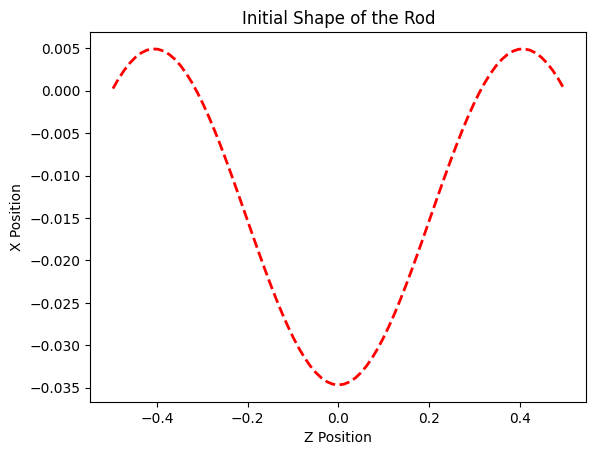

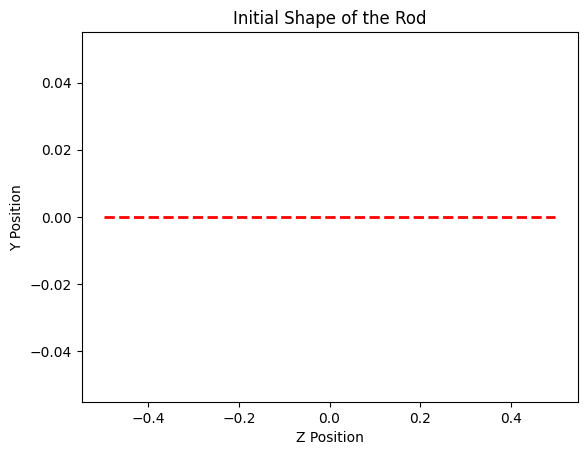

In [5]:
def solve_tau(mu, tau_guess=8.0):
    """
    Solves for tau in the equation:
    (tau - sin(tau)) / (2*tau - 2*tau*cos(tau)) = mu
    
    Parameters:
    - mu: Given value of mu
    - tau_guess: Initial guess for tau (default: 1.0)
    
    Returns:
    - tau: The root that satisfies the equation
    """
    def equation(tau):
        return (tau - np.sin(tau)) / (2 * tau - 2 * tau * np.cos(tau)) - mu

    lower_bound = max(1e-6, tau_guess * 0.7)
    upper_bound = tau_guess * 2.0

    try:
        solution = root_scalar(equation, bracket=[lower_bound, upper_bound], method='brentq')
        if solution.converged:
            return solution.root
        else:
            raise ValueError("Solver did not converge!")
    except ValueError:
        print("Brentq method failed, trying Newton's method...")
        solution = root_scalar(equation, x0=tau_guess, method='newton')
        if solution.converged:
            return solution.root
        else:
            raise ValueError("Solver did not converge with Newton’s method!")

tau_guess = 6.8
tau_solution = solve_tau(mu, tau_guess)
print(f"Solution for tau with mu={mu}: {tau_solution}")

x_resc = (1-alpha**2 * mu)

def shape(x_v, tau):
    x = (x_v+0.5)
    result = 1.01* alpha * ((-1 + np.cos(x * tau)) * (1 / np.tan(tau / 2)) + np.sin(x * tau)) / tau
    return result


# Define the initial shape: A sinusoidal wave along the Z-axis
z_positions = np.linspace(- 0.5 * x_resc , 0.5 * x_resc, n_elem + 1)
y_positions = np.zeros_like(z_positions)
x_positions = shape(z_positions, tau_solution)

# Assign to positions array
positions[0, :] = x_positions
positions[1, :] = y_positions
positions[2, :] = z_positions

#plot initial shape
plt.plot(positions[2, :], positions[0, :], "r--", lw=2.0)
plt.xlabel("Z Position")
plt.ylabel("X Position")
plt.title("Initial Shape of the Rod")
plt.show()

#plot initial shape
plt.plot(positions[2, :], positions[1, :], "r--", lw=2.0)
plt.xlabel("Z Position")
plt.ylabel("Y Position")
plt.title("Initial Shape of the Rod")
plt.show()

butterfly_rod = ea.CosseratRod.straight_rod(
    n_elem,
    start=origin.reshape(3),
    direction=np.array([0.0, 0.0, 1.0]),
    normal=np.array([0.0, 1.0, 0.0]),
    base_length=total_length,
    base_radius=base_radius,
    density=density,
    youngs_modulus=youngs_modulus,
    shear_modulus=shear_modulus,
    position=positions,
    rest_lenths = np.ones(n_elem) * dl,
)



butterfly_sim.append(butterfly_rod)


butrodI=[butterfly_rod.rest_sigma.copy(),
butterfly_rod.sigma.copy(),
butterfly_rod.kappa.copy(),
butterfly_rod.position_collection.copy(),
butterfly_rod.director_collection.copy(),
butterfly_rod.rest_voronoi_lengths.copy()]



In [6]:
dt = 0.0002
damping_constant = 0.01

damping_constant = damping_constant  # Adjust this value to increase or decrease damping
butterfly_sim.dampen(butterfly_rod).using(
    AnalyticalLinearDamper,
    damping_constant=damping_constant,
    time_step=dt,

)

butterfly_sim.constrain(butterfly_rod).using(
    FixedConstraint,
    constrained_position_idx=(0,-1), 
    constrained_director_idx=(0,-1),
)       




# Add call backs
class VelocityCallBack(ea.CallBackBaseClass):
    """
    Call back function for continuum snake
    """

    def __init__(self, step_skip: int, callback_params: dict):
        ea.CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            # Collect x
            self.callback_params["position"].append(system.position_collection.copy())
            # Collect energies as well
            self.callback_params["te"].append(system.compute_translational_energy())
            self.callback_params["re"].append(system.compute_rotational_energy())
            self.callback_params["se"].append(system.compute_shear_energy())
            self.callback_params["be"].append(system.compute_bending_energy())
            # Collect position of the middle node
            middle_index = system.n_elems // 2
            self.callback_params["middle_position"].append(system.position_collection[:, middle_index].copy())
            # Collect angle in the x-z plane of the middle node
            tangent_middle = system.position_collection[:, middle_index + 1] - system.position_collection[:, middle_index - 1]
            angle_middle = np.arctan2(tangent_middle[0], tangent_middle[2])
            tangent_left =system.position_collection[:, 1] - system.position_collection[:, 0]
            angle_left = np.arctan2(tangent_left[0], tangent_left[2])
            tangent_right=system.position_collection[:, -1] - system.position_collection[:, -2]
            angle_right = np.arctan2(tangent_right[0], tangent_right[2])
            self.callback_params["angle_left"].append(angle_left)
            self.callback_params["angle_right"].append(angle_right)
            self.callback_params["angle_middle"].append(angle_middle)
            # Collect angles at the two ends
            return

recorded_history = ea.defaultdict(list)
# initially record history
recorded_history["time"].append(0.0)
recorded_history["position"].append(butterfly_rod.position_collection.copy())
recorded_history["te"].append(butterfly_rod.compute_translational_energy())
recorded_history["re"].append(butterfly_rod.compute_rotational_energy())
recorded_history["se"].append(butterfly_rod.compute_shear_energy())
recorded_history["be"].append(butterfly_rod.compute_bending_energy())
middle_index = butterfly_rod.n_elems // 2
recorded_history["middle_position"].append(butterfly_rod.position_collection[:, middle_index].copy())
tangent_middle = butterfly_rod.position_collection[:, middle_index + 1] - butterfly_rod.position_collection[:, middle_index - 1]
recorded_history["angle_middle"].append(np.arctan2(tangent_middle[0], tangent_middle[2]))
tangent_left = butterfly_rod.position_collection[:, 1] - butterfly_rod.position_collection[:, 0]
recorded_history["angle_left"].append(np.arctan2(tangent_left[0], tangent_left[2]))
tangent_right=butterfly_rod.position_collection[:, -1] - butterfly_rod.position_collection[:, -2]
recorded_history["angle_right"].append(np.arctan2(tangent_right[0], tangent_right[2]))




butterfly_sim.collect_diagnostics(butterfly_rod).using(
    VelocityCallBack, step_skip=100, callback_params=recorded_history
)


butterfly_sim.finalize()
timestepper = ea.PositionVerlet()
# timestepper = PEFRL()



total_steps = 500000
final_time = dt * total_steps

total_steps = int(total_steps)
print("Total steps", total_steps)
ea.integrate(timestepper, butterfly_sim, final_time, total_steps)


Total steps 500000


100%|██████████| 500000/500000 [00:17<00:00, 29334.35it/s]

Final time of simulation is :  100.00000000219612


100.00000000219612

In [7]:
#  show all data from butterfly rod,rod.rest_sigma           # Shape: (3, n_elements) - Rest strains (stretching and shear) rod.sigma                # Current strains rod.rest_kappa           # Shape: (3, n_elements) - Rest curvatures (bending and twisting)rod.kappa
print("Rod data:")
print("Rod rest sigma:", butterfly_rod.rest_sigma)
print("Rod current sigma:", butterfly_rod.sigma)
print("Rod current kappa:", butterfly_rod.kappa)
print("Rod position:", butterfly_rod.position_collection)
print("Directors position:", butterfly_rod.director_collection)
print("Rest voroni lengths:", butterfly_rod.rest_voronoi_lengths)
print("Rest lengths:", butterfly_rod.rest_lengths)
butrodF=[butterfly_rod.rest_sigma.copy(),
butterfly_rod.sigma.copy(),
butterfly_rod.kappa.copy(),
butterfly_rod.position_collection.copy(),
butterfly_rod.director_collection.copy(),
butterfly_rod.rest_voronoi_lengths.copy(),]

Rod data:
Rod rest sigma: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Rod current sigma: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [8]:
print("KE:", butterfly_rod.compute_translational_energy())
print("RE:", butterfly_rod.compute_rotational_energy())
print("Bend:", butterfly_rod.compute_bending_energy())
print("Shear:", butterfly_rod.compute_shear_energy())



KE: 1.333517921258363e-12
RE: 2.0555128464909876e-19
Bend: 0.004705026967399921
Shear: 4.4169303612862163e-05


So, we have reached equilibrium apparently, where only beind energy matters, as we would expect. 

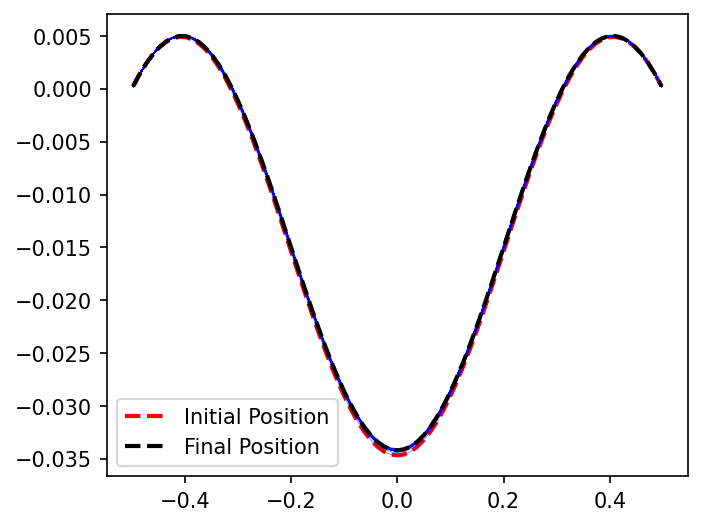

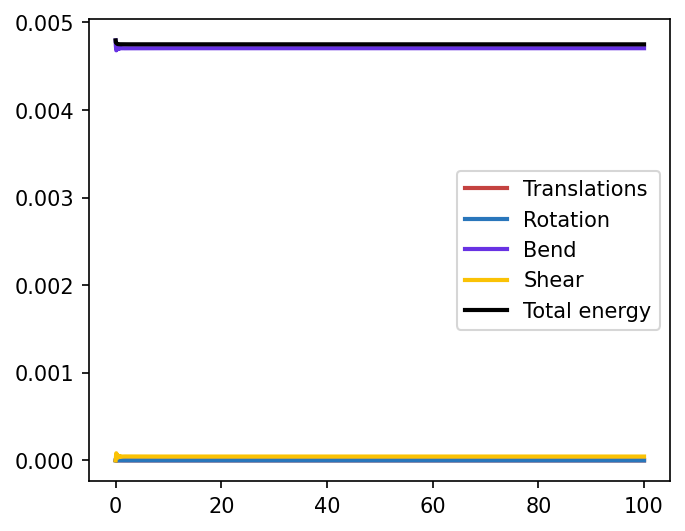

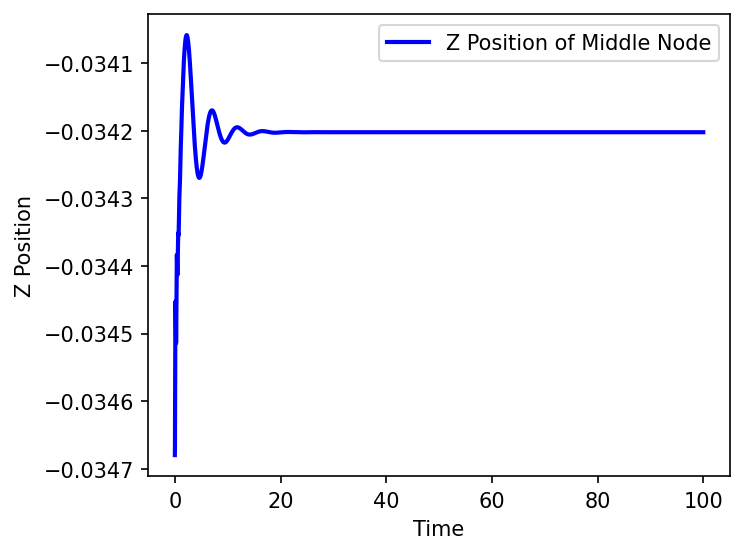

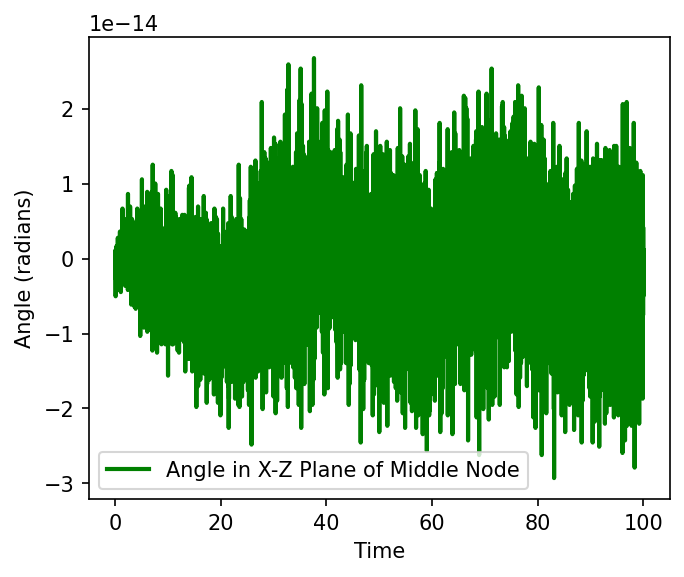

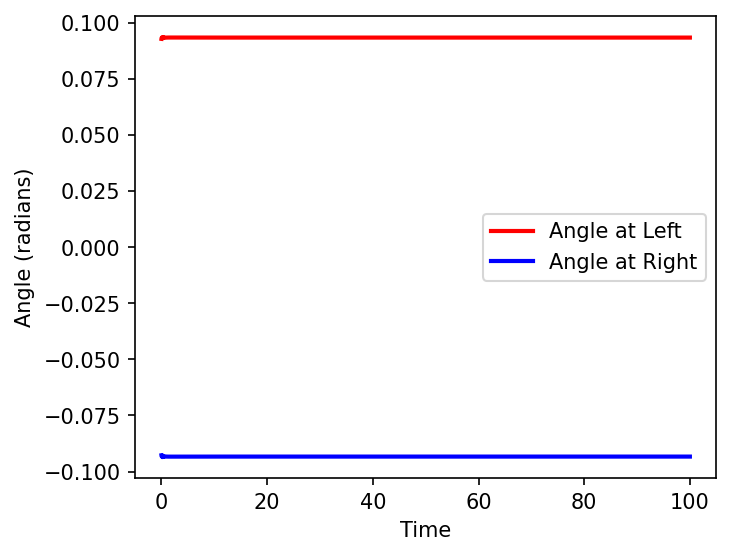

In [9]:
if PLOT_FIGURE:
    # Plot the histories
    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    positions = recorded_history["position"]
    
    # Record first position
    first_position = positions.pop(0)
    ax.plot(first_position[2, ...], first_position[0, ...], "r--", lw=2.0, label="Initial Position")  # Red dashed line
    
    n_positions = len(positions)
    step = max(1, n_positions // 200)  # Adjust step to plot fewer timestamps
    for i, pos in enumerate(positions[::step]):
        plot_alpha = np.exp(i / (n_positions // step) - 1)
        ax.plot(pos[2, ...], pos[0, ...], "b", lw=0.6, alpha=plot_alpha)  # Blue lines for intermediate positions
        
    # Final position is also separate
    last_position = positions.pop()
    ax.plot(last_position[2, ...], last_position[0, ...], "k--", lw=2.0, label="Final Position")  # Black dashed line
    
    ax.legend()
    # Don't block
    plt.show()

    # Plot the energies
    energy_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    energy_ax = energy_fig.add_subplot(111)
    times = np.asarray(recorded_history["time"])
    te = np.asarray(recorded_history["te"])
    re = np.asarray(recorded_history["re"])
    be = np.asarray(recorded_history["be"])
    se = np.asarray(recorded_history["se"])

    energy_ax.plot(times, te, c=to_rgb("xkcd:reddish"), lw=2.0, label="Translations")
    energy_ax.plot(times, re, c=to_rgb("xkcd:bluish"), lw=2.0, label="Rotation")
    energy_ax.plot(times, be, c=to_rgb("xkcd:burple"), lw=2.0, label="Bend")
    energy_ax.plot(times, se, c=to_rgb("xkcd:goldenrod"), lw=2.0, label="Shear")
    energy_ax.plot(times, te + re + be + se, c="k", lw=2.0, label="Total energy")
    energy_ax.legend()
    # Don't block
    plt.show()

    # Plot the position of the middle node
    middle_position_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    middle_position_ax = middle_position_fig.add_subplot(111)
    middle_positions = np.asarray(recorded_history["middle_position"])
    middle_position_ax.plot(times, middle_positions[:, 0], c="b", lw=2.0, label="Z Position of Middle Node")
    middle_position_ax.set_xlabel("Time")
    middle_position_ax.set_ylabel("Z Position")
    middle_position_ax.legend()
    plt.show()

    # Plot the angle in the x-z plane of the middle node
    angle_middle_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    angle_middle_ax = angle_middle_fig.add_subplot(111)
    angles_middle = np.asarray(recorded_history["angle_middle"])
    angle_middle_ax.plot(times, angles_middle, c="g", lw=2.0, label="Angle in X-Z Plane of Middle Node")
    angle_middle_ax.set_xlabel("Time")
    angle_middle_ax.set_ylabel("Angle (radians)")
    angle_middle_ax.legend()
    plt.show()

     # Plot the angles at the two ends
    angle_ends_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    angle_ends_ax = angle_ends_fig.add_subplot(111)
    angles_start = np.asarray(recorded_history["angle_left"])
    angles_end = np.asarray(recorded_history["angle_right"])
    angle_ends_ax.plot(times, angles_start, c="r", lw=2.0, label="Angle at Left")
    angle_ends_ax.plot(times, angles_end, c="b", lw=2.0, label="Angle at Right")
    angle_ends_ax.set_xlabel("Time")
    angle_ends_ax.set_ylabel("Angle (radians)")
    angle_ends_ax.legend()
    plt.show()

    if SAVE_FIGURE:
        fig.savefig("butterfly.png")
        energy_fig.savefig("energies.png")
        middle_position_fig.savefig("middle_position.png")
        angle_middle_fig.savefig("angle_middle.png")

if SAVE_RESULTS:
    import pickle

    filename = "butterfly_data.dat"
    file = open(filename, "wb")
    pickle.dump(butterfly_rod, file)
    file.close()

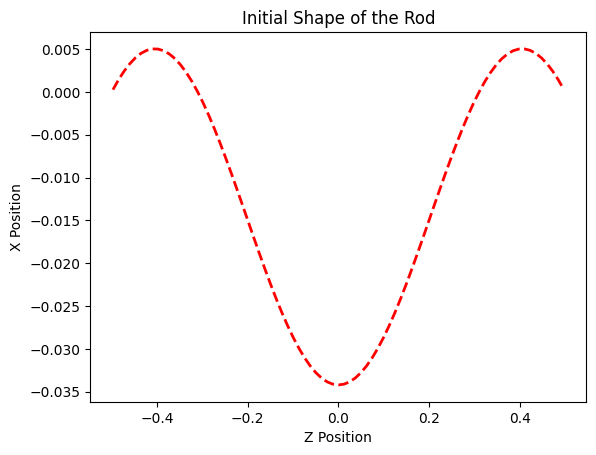

[[[ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 1.          1.          1.          1.          1.
    1.          1.          1.          1.          1.
 

100%|██████████| 100000/100000 [00:03<00:00, 29911.75it/s]


Final time of simulation is :  19.99999999996673


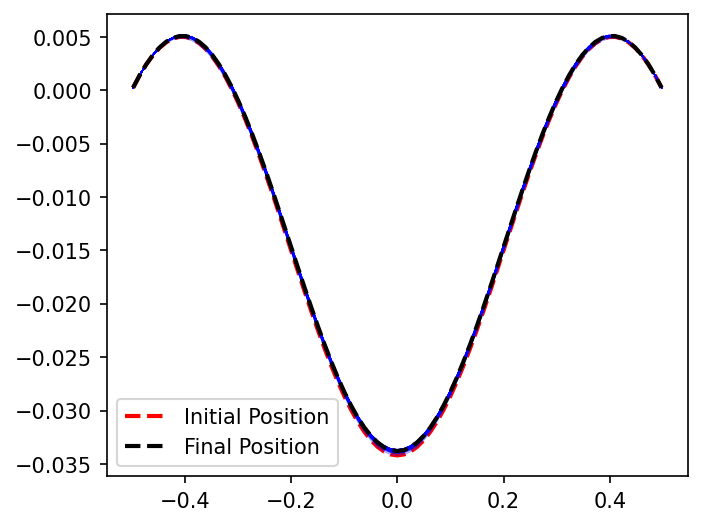

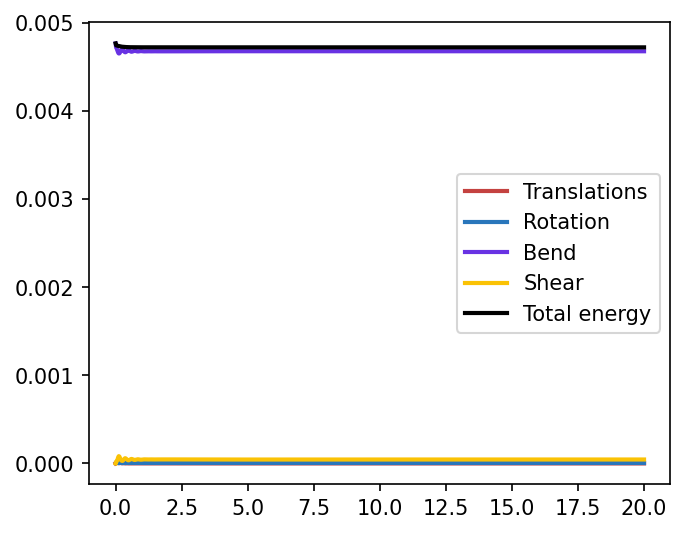

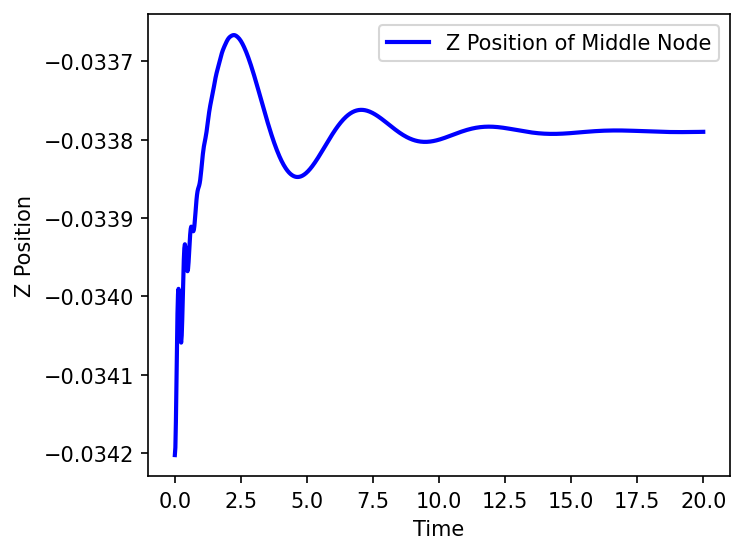

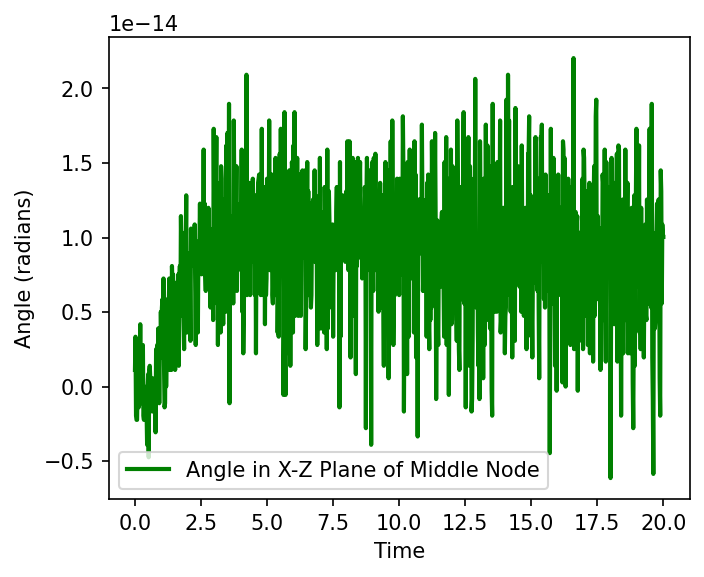

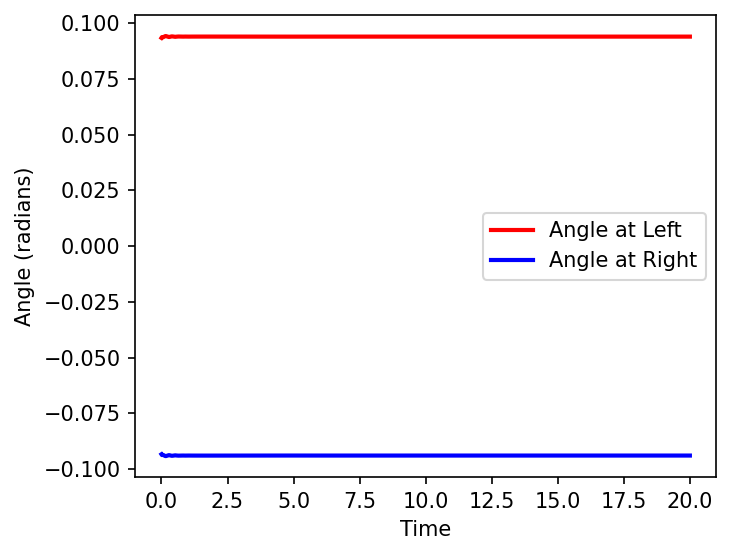

In [10]:
positionsI = np.empty((MaxDimension.value(), n_elem + 1)) # Positions of the rod
directorsI= np.zeros((3, 3, n_elem)) # Directors of the rod


# define the initial shape as the final result from the previous simulation:
positionsI = butterfly_rod.position_collection.copy()
#Show strains from butterfly_rod
directorsI=butterfly_rod.director_collection.copy()



# Create a class that inherits from the base class
class ButterflySimulator2(ea.BaseSystemCollection, ea.CallBacks, ea.Damping, ea.Constraints, ea.Forcing):
    pass

butterfly2_sim = ButterflySimulator2()


# Create the rod using the CosseratRod constructor initialising it with the shape and strain from the butterfly simulaiton
butterfly2_rod = ea.CosseratRod.straight_rod(
    n_elem,
    start=origin.reshape(3),
    direction=np.array([0.0, 0.0, 1.0]),
    normal=np.array([0.0, 1.0, 0.0]),
    base_length=total_length,
    base_radius=base_radius,
    density=density,
    youngs_modulus=youngs_modulus,
    shear_modulus=shear_modulus,
    position = positionsI,
    director=directorsI,
)




#plot initial shape of the rod  
plt.plot(positionsI[2, :], positionsI[0, :], "r--", lw=2.0)
plt.xlabel("Z Position")
plt.ylabel("X Position")
plt.title("Initial Shape of the Rod")

plt.show()

# Append the rod to the system
butterfly2_sim.append(butterfly2_rod)

print(directorsI)
print("Rod data:")
print("Rod rest sigma:", butterfly2_rod.rest_sigma)
print("Rod current sigma:", butterfly2_rod.sigma)
print("Rod rest kappa:", butterfly2_rod.rest_kappa)
print("Rod current kappa:", butterfly2_rod.kappa)
print("Rod position:", butterfly2_rod.position_collection)
print("Rod director:", butterfly2_rod.director_collection)
print("Rod velocity:", butterfly2_rod.velocity_collection)
print("Rest voroni lengths:", butterfly2_rod.rest_voronoi_lengths)

butrod2I=[butterfly2_rod.rest_sigma.copy(),
butterfly2_rod.sigma.copy(),
butterfly2_rod.kappa.copy(),
butterfly2_rod.position_collection.copy(),
butterfly2_rod.director_collection.copy(),
butterfly2_rod.rest_voronoi_lengths.copy()]


damping_constant = damping_constant  # Adjust this value to increase or decrease damping
butterfly2_sim.dampen(butterfly2_rod).using(
    AnalyticalLinearDamper,
    damping_constant=damping_constant,
    time_step=dt,
)

butterfly2_sim.constrain(butterfly2_rod).using(
    FixedConstraint,
    constrained_position_idx=(0,-1), 
    constrained_director_idx=(0,-1),
)       



# Add call backs
class VelocityCallBack(ea.CallBackBaseClass):
    """
    Call back function for continuum snake
    """

    def __init__(self, step_skip: int, callback_params: dict):
        ea.CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            # Collect x
            self.callback_params["position"].append(system.position_collection.copy())
            # Collect energies as well
            self.callback_params["te"].append(system.compute_translational_energy())
            self.callback_params["re"].append(system.compute_rotational_energy())
            self.callback_params["se"].append(system.compute_shear_energy())
            self.callback_params["be"].append(system.compute_bending_energy())
            # Collect position of the middle node
            middle_index = system.n_elems // 2
            self.callback_params["middle_position"].append(system.position_collection[:, middle_index].copy())
            # Collect angle in the x-z plane of the middle node
            tangent_middle = system.position_collection[:, middle_index + 1] - system.position_collection[:, middle_index - 1]
            angle_middle = np.arctan2(tangent_middle[0], tangent_middle[2])
            tangent_left = system.position_collection[:, 1] - system.position_collection[:, 0]
            angle_left = np.arctan2(tangent_left[0], tangent_left[2])
            tangent_right = system.position_collection[:, -1] - system.position_collection[:, -2]
            angle_right = np.arctan2(tangent_right[0], tangent_right[2])
            self.callback_params["angle_left"].append(angle_left)
            self.callback_params["angle_right"].append(angle_right)
            self.callback_params["angle_middle"].append(angle_middle)
            return

recorded_history = ea.defaultdict(list)
# initially record history
recorded_history["time"].append(0.0)
recorded_history["position"].append(butterfly2_rod.position_collection.copy())
recorded_history["te"].append(butterfly2_rod.compute_translational_energy())
recorded_history["re"].append(butterfly2_rod.compute_rotational_energy())
recorded_history["se"].append(butterfly2_rod.compute_shear_energy())
recorded_history["be"].append(butterfly2_rod.compute_bending_energy())
middle_index = butterfly2_rod.n_elems // 2
recorded_history["middle_position"].append(butterfly2_rod.position_collection[:, middle_index].copy())
tangent_middle = butterfly2_rod.position_collection[:, middle_index + 1] - butterfly2_rod.position_collection[:, middle_index - 1]
recorded_history["angle_middle"].append(np.arctan2(tangent_middle[0], tangent_middle[2]))
tangent_left = butterfly2_rod.position_collection[:, 1] - butterfly2_rod.position_collection[:, 0]
recorded_history["angle_left"].append(np.arctan2(tangent_left[0], tangent_left[2]))
tangent_right = butterfly2_rod.position_collection[:, -1] - butterfly2_rod.position_collection[:, -2]
recorded_history["angle_right"].append(np.arctan2(tangent_right[0], tangent_right[2]))

butterfly2_sim.collect_diagnostics(butterfly2_rod).using(
    VelocityCallBack, step_skip=100, callback_params=recorded_history
)



butterfly2_sim.finalize()
timestepper = ea.PositionVerlet()
# timestepper = PEFRL()

total_steps = 100000
final_time = dt * total_steps

total_steps = int(total_steps)
print("Total steps", total_steps)
ea.integrate(timestepper, butterfly2_sim, final_time, total_steps)



if PLOT_FIGURE:
    # Plot the histories
    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    positions = recorded_history["position"]
    
    # Record first position
    first_position = positions.pop(0)
    ax.plot(first_position[2, ...], first_position[0, ...], "r--", lw=2.0, label="Initial Position")  # Red dashed line
    
    n_positions = len(positions)
    step = max(1, n_positions // 200)  # Adjust step to plot fewer timestamps
    for i, pos in enumerate(positions[::step]):
        plot_alpha = np.exp(i / (n_positions // step) - 1)
        ax.plot(pos[2, ...], pos[0, ...], "b", lw=0.6, alpha=plot_alpha)  # Blue lines for intermediate positions
        
    # Final position is also separate
    last_position = positions.pop()
    ax.plot(last_position[2, ...], last_position[0, ...], "k--", lw=2.0, label="Final Position")  # Black dashed line
    
    ax.legend()
    # Don't block
    plt.show()

    # Plot the energies
    energy_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    energy_ax = energy_fig.add_subplot(111)
    times = np.asarray(recorded_history["time"])
    te = np.asarray(recorded_history["te"])
    re = np.asarray(recorded_history["re"])
    be = np.asarray(recorded_history["be"])
    se = np.asarray(recorded_history["se"])

    energy_ax.plot(times, te, c=to_rgb("xkcd:reddish"), lw=2.0, label="Translations")
    energy_ax.plot(times, re, c=to_rgb("xkcd:bluish"), lw=2.0, label="Rotation")
    energy_ax.plot(times, be, c=to_rgb("xkcd:burple"), lw=2.0, label="Bend")
    energy_ax.plot(times, se, c=to_rgb("xkcd:goldenrod"), lw=2.0, label="Shear")
    energy_ax.plot(times, te + re + be + se, c="k", lw=2.0, label="Total energy")
    energy_ax.legend()
    # Don't block
    plt.show()

    # Plot the position of the middle node
    middle_position_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    middle_position_ax = middle_position_fig.add_subplot(111)
    middle_positions = np.asarray(recorded_history["middle_position"])
    middle_position_ax.plot(times, middle_positions[:, 0], c="b", lw=2.0, label="Z Position of Middle Node")
    middle_position_ax.set_xlabel("Time")
    middle_position_ax.set_ylabel("Z Position")
    middle_position_ax.legend()
    plt.show()

    # Plot the angle in the x-z plane of the middle node
    angle_middle_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    angle_middle_ax = angle_middle_fig.add_subplot(111)
    angles_middle = np.asarray(recorded_history["angle_middle"])
    angle_middle_ax.plot(times, angles_middle, c="g", lw=2.0, label="Angle in X-Z Plane of Middle Node")
    angle_middle_ax.set_xlabel("Time")
    angle_middle_ax.set_ylabel("Angle (radians)")
    angle_middle_ax.legend()
    plt.show()

     # Plot the angles at the two ends
    angle_ends_fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    angle_ends_ax = angle_ends_fig.add_subplot(111)
    angles_start = np.asarray(recorded_history["angle_left"])
    angles_end = np.asarray(recorded_history["angle_right"])
    angle_ends_ax.plot(times, angles_start, c="r", lw=2.0, label="Angle at Left")
    angle_ends_ax.plot(times, angles_end, c="b", lw=2.0, label="Angle at Right")
    angle_ends_ax.set_xlabel("Time")
    angle_ends_ax.set_ylabel("Angle (radians)")
    angle_ends_ax.legend()
    plt.show()

    if SAVE_FIGURE:
        fig.savefig("butterfly.png")
        energy_fig.savefig("energies.png")
        middle_position_fig.savefig("middle_position.png")
        angle_middle_fig.savefig("angle_middle.png")

if SAVE_RESULTS:
    import pickle

    filename = "butterfly_data.dat"
    file = open(filename, "wb")
    pickle.dump(butterfly_rod, file)
    file.close()